# Examples: images

In [1]:
import importlib
import sys
sys.path.append('..')

from ipywidgets import interact
from ipywidgets import widgets
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
from psdist import utils
import scipy.ndimage

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

## 2D image 

In [3]:
res = 50
state = np.random.RandomState(1951)
xx = np.linspace(-5.0, 5.0, res)
X, Y = np.meshgrid(xx, xx, indexing='ij')
f = np.zeros((res, res))
for _ in range(4):
    sig = state.uniform(0.5, 1.5, size=2)
    mu = state.uniform(-2.0, 2.0, size=2)
    f += np.exp(-0.5 * (((X - mu[0]) / sig[0])**2 + ((Y - mu[1]) / sig[1])**2))
f = f**2
f = ps.image.process(f, norm='max')
f = ps.image.process(f, thresh=0.001)

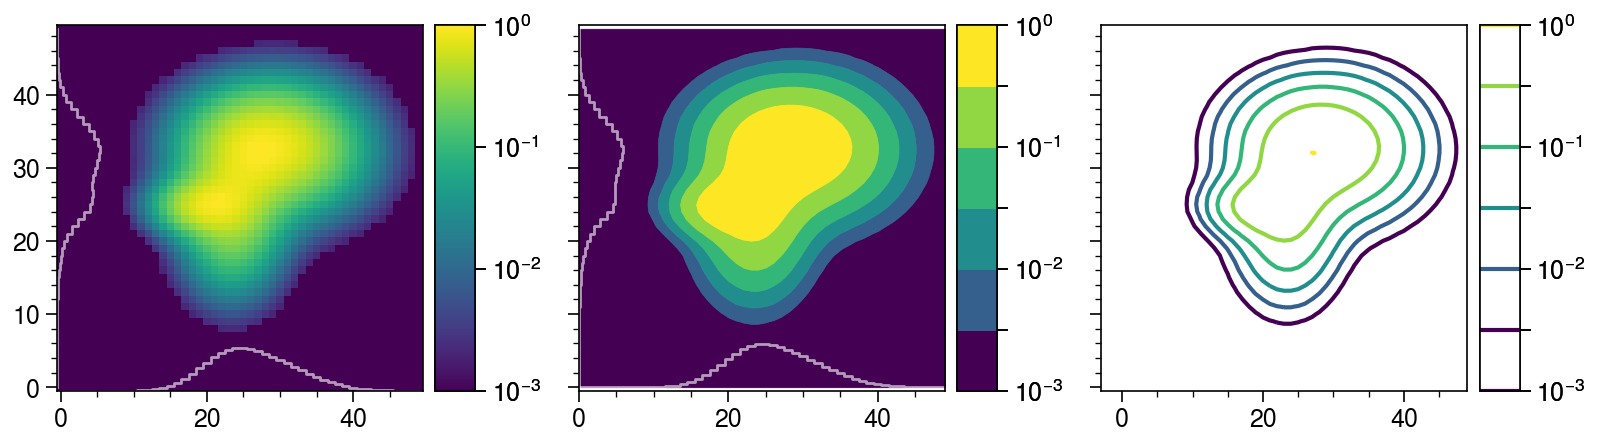

In [4]:
fig, axs = pplt.subplots(ncols=3, figwidth=8.0)
for ax, kind in zip(axs, ['pcolor', 'contourf', 'contour']):
    ax = psv.image.plot2d(
        f, coords=None, ax=ax,
        kind=kind,
        profx=True, profy=True, prof_kws=dict(kind='step'),
        process_kws=dict(thresh=10.0**-3.0),
        offset=1.0,
        rms_ellipse=False, 
        colorbar=True,
        norm='log',
        vmax=1.0,
        vmin=1.0e-3,
    )

### Joint plot 

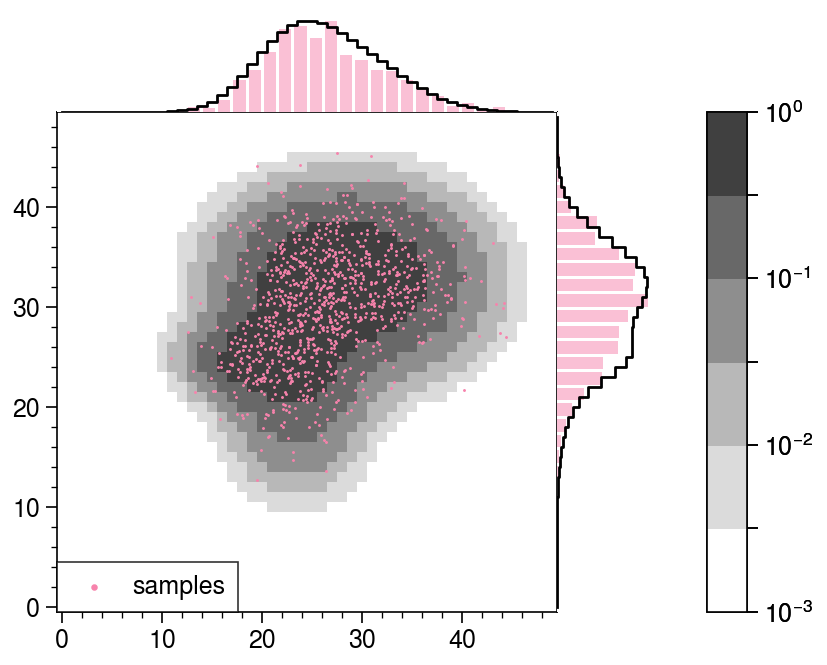

In [5]:
g = psv.image.joint(
    f, coords=None, 
    cmap=pplt.Colormap('greys', left=0.0, right=0.8), norm='log',
    colorbar=True, discrete=True, vmax=1.0,
)
g.plot_cloud(
    ps.image.sample_grid(f, coords=None, samples=1000),
    marg_hist_kws=dict(bins='auto'),
    kind='scatter', size=0.2, color='pink4',
    marg_kws=dict(kind='bar', color='pink4', alpha=0.5),
    label='samples',
)
g.ax.legend(ms=3, loc='ll')

## ND image 

In [6]:
res = 50
n = 4
dims = ["x", "px", "y", "py", "z"][:n]
pairs = [(i, j) for i in range(n) for j in range(i)]

shape = tuple(n * [res])
xmax = 5.0
coords = n * [np.linspace(-xmax, xmax, res)]
COORDS = np.meshgrid(*coords, indexing='ij')
R = np.sqrt(np.sum([C**2 for C in COORDS], axis=0))

# Start with gaussian * cosine
f = 0.25 * np.exp(-0.5 * (R / 2.0)) * np.cos(3.0 * R)**2
f[R > 4.0] = 0.0
for _ in range(8):
    # Generate a Gaussian distribution with random mean and std.
    sig = state.uniform(0.5, 1.0, size=n)
    mu = state.uniform(-3.0, 3.0, size=n)
    argument = np.zeros(shape)
    for i in range(n):
        argument += ((COORDS[i] - mu[i]) / sig[i])**2
    # Add random linear correlations.
    for (i, j) in pairs:
        r = state.uniform(-0.5, 0.5)
        U = (COORDS[i] - mu[i]) / sig[i]
        V = (COORDS[j] - mu[j]) / sig[j]
        argument += r * U * V
    f += np.exp(-0.5 * argument)    
f = ps.image.process(f, norm='max')
f = ps.image.process(f, thresh=0.001)

### Corner plot 

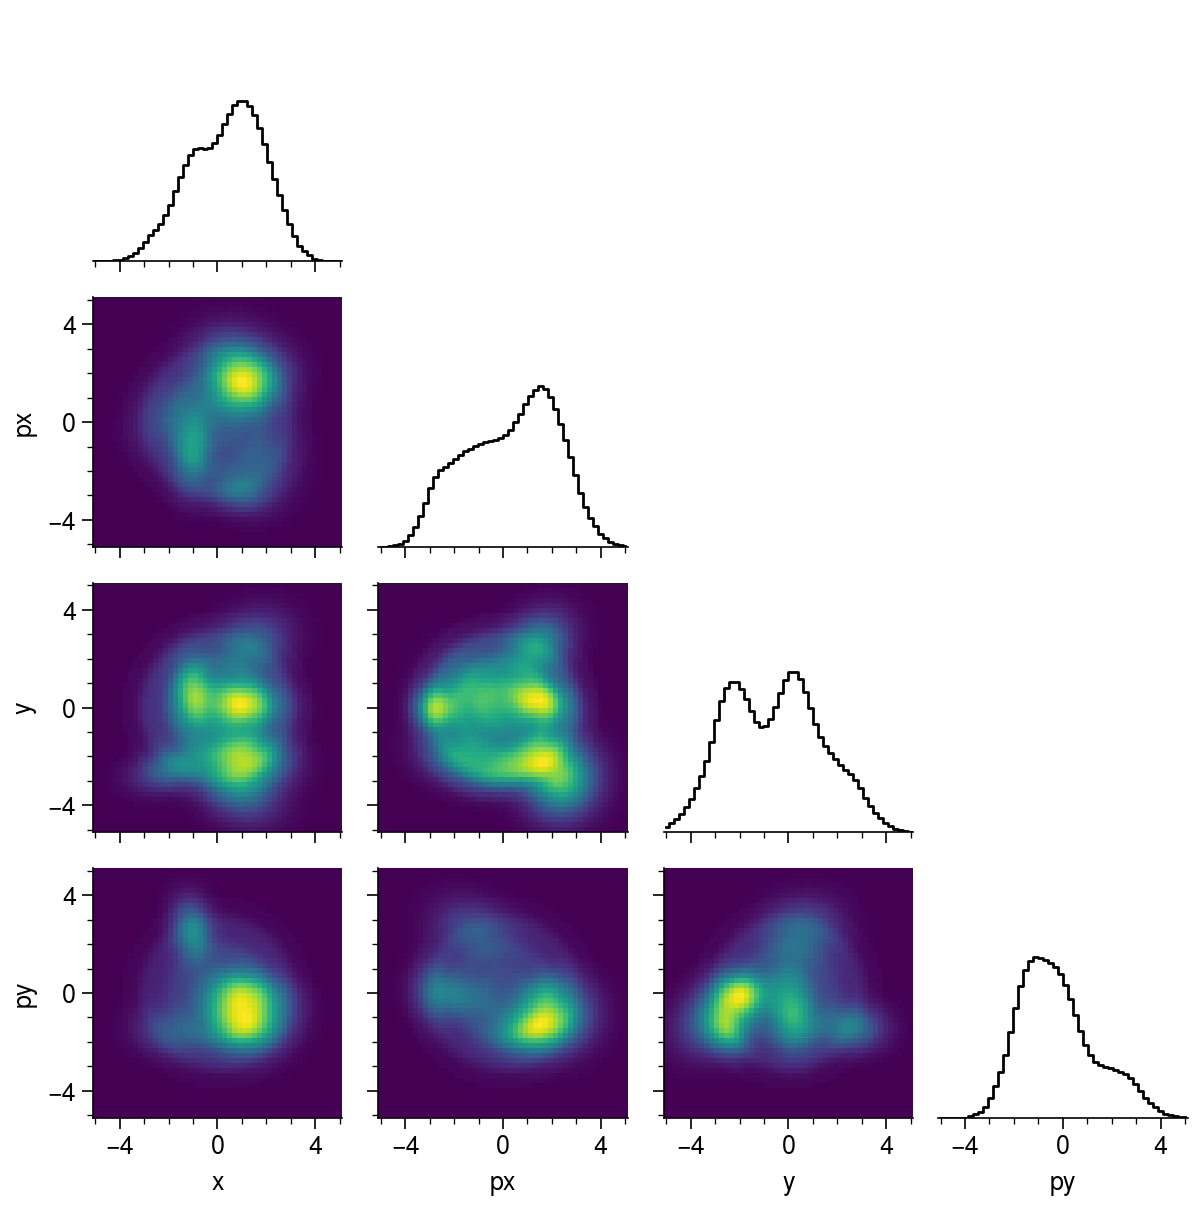

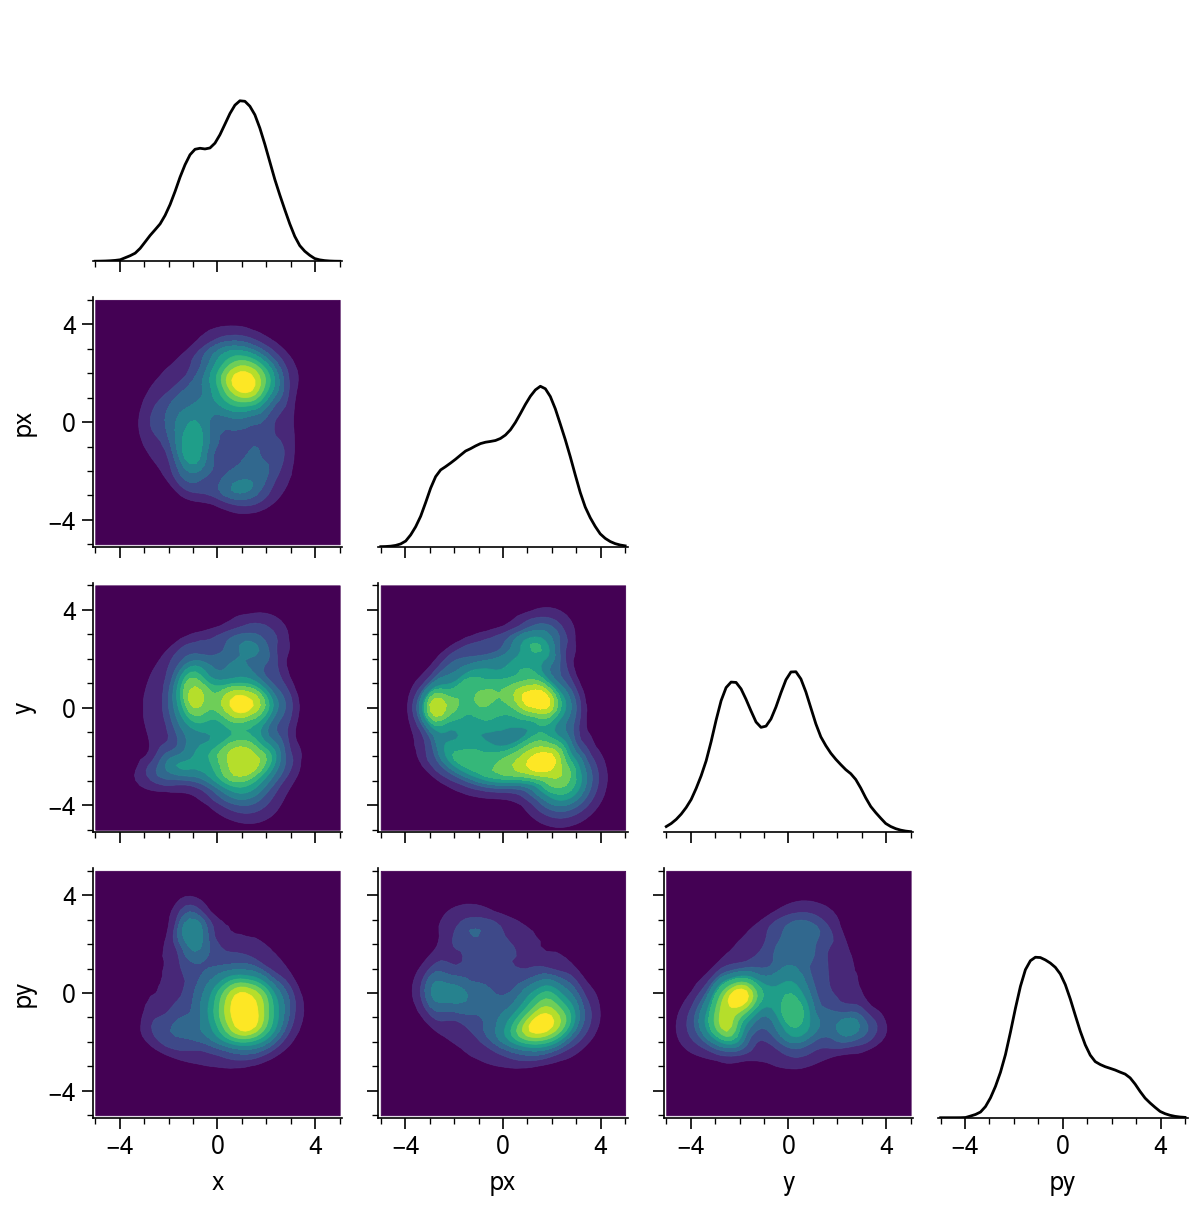

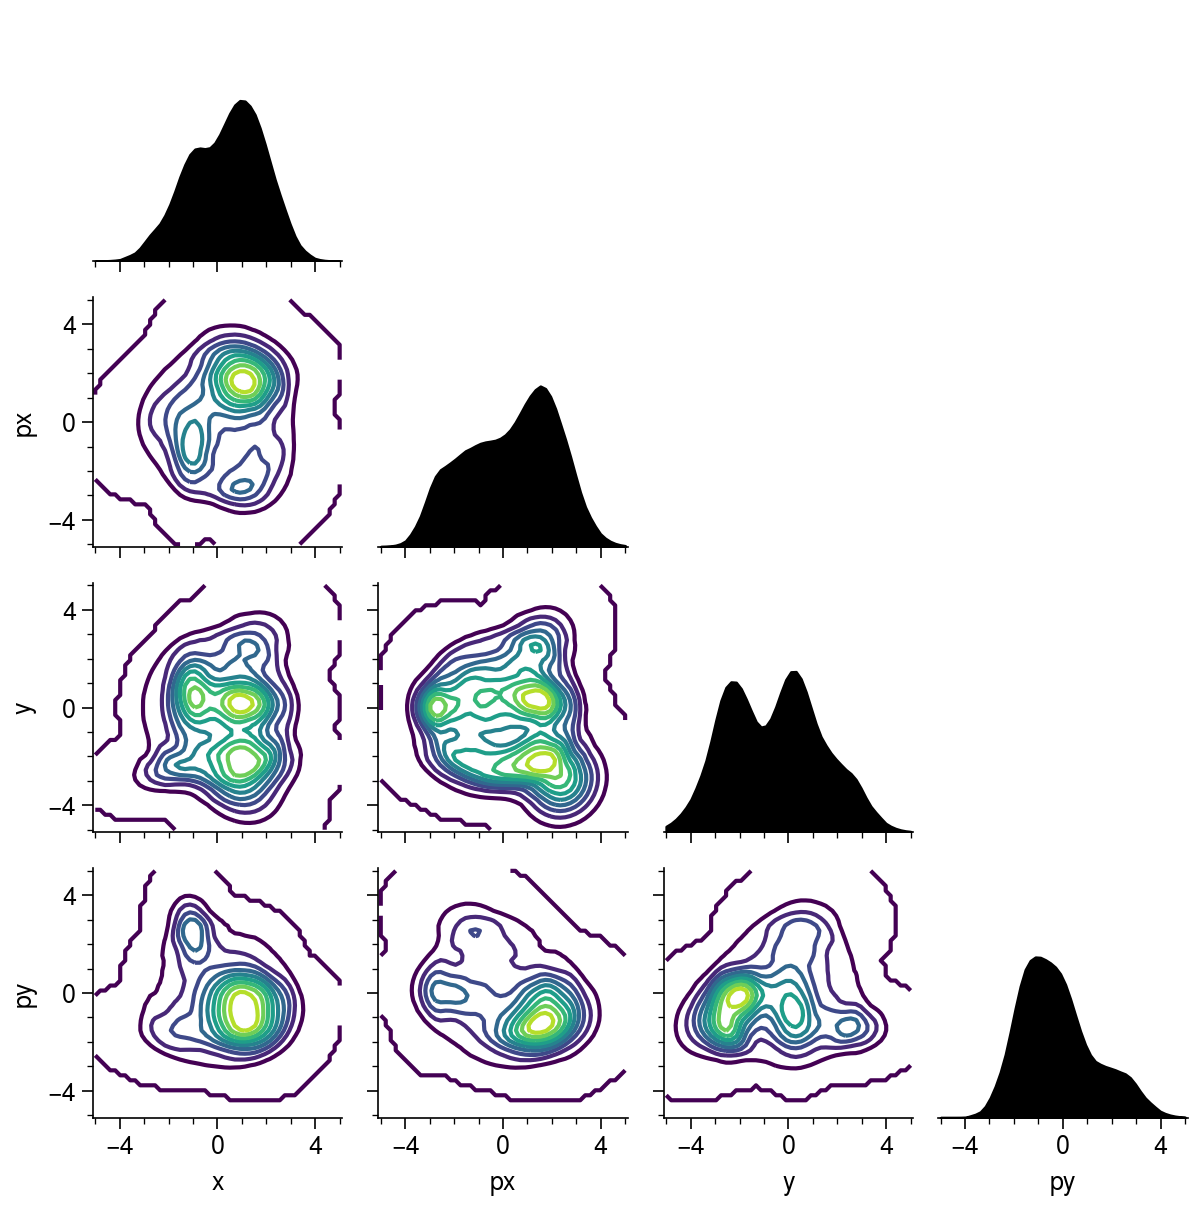

In [7]:
kinds = ['pcolor', 'contourf', 'contour']
diag_kinds = ['step', 'line', 'linefilled']
for kind, diag_kind in zip(kinds, diag_kinds):
    cgrid = psv.image.corner(
        f, coords=coords, labels=dims,
        grid_kws=dict(), 
        diag_kws=dict(kind=diag_kind), 
        kind=kind,
    )
    plt.show()

Don't plot diagonals; plot 1D projections on top of 2D projections.

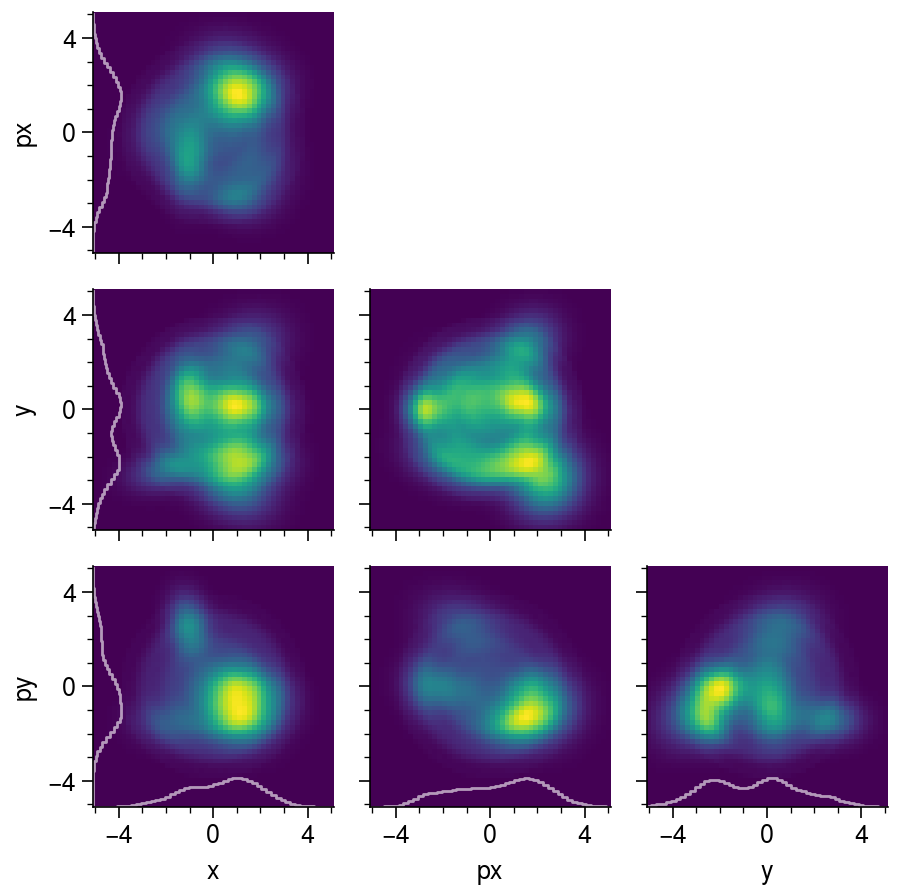

In [8]:
cgrid = psv.image.corner(
    f, coords=coords, labels=dims,
    grid_kws=dict(diag=False), 
    diag_kws=dict(kind=diag_kind), 
    prof_edge_only=True,
    profx=True, profy=True, prof_kws=dict(color='white'),
)

Use `CornerGrid` directly:

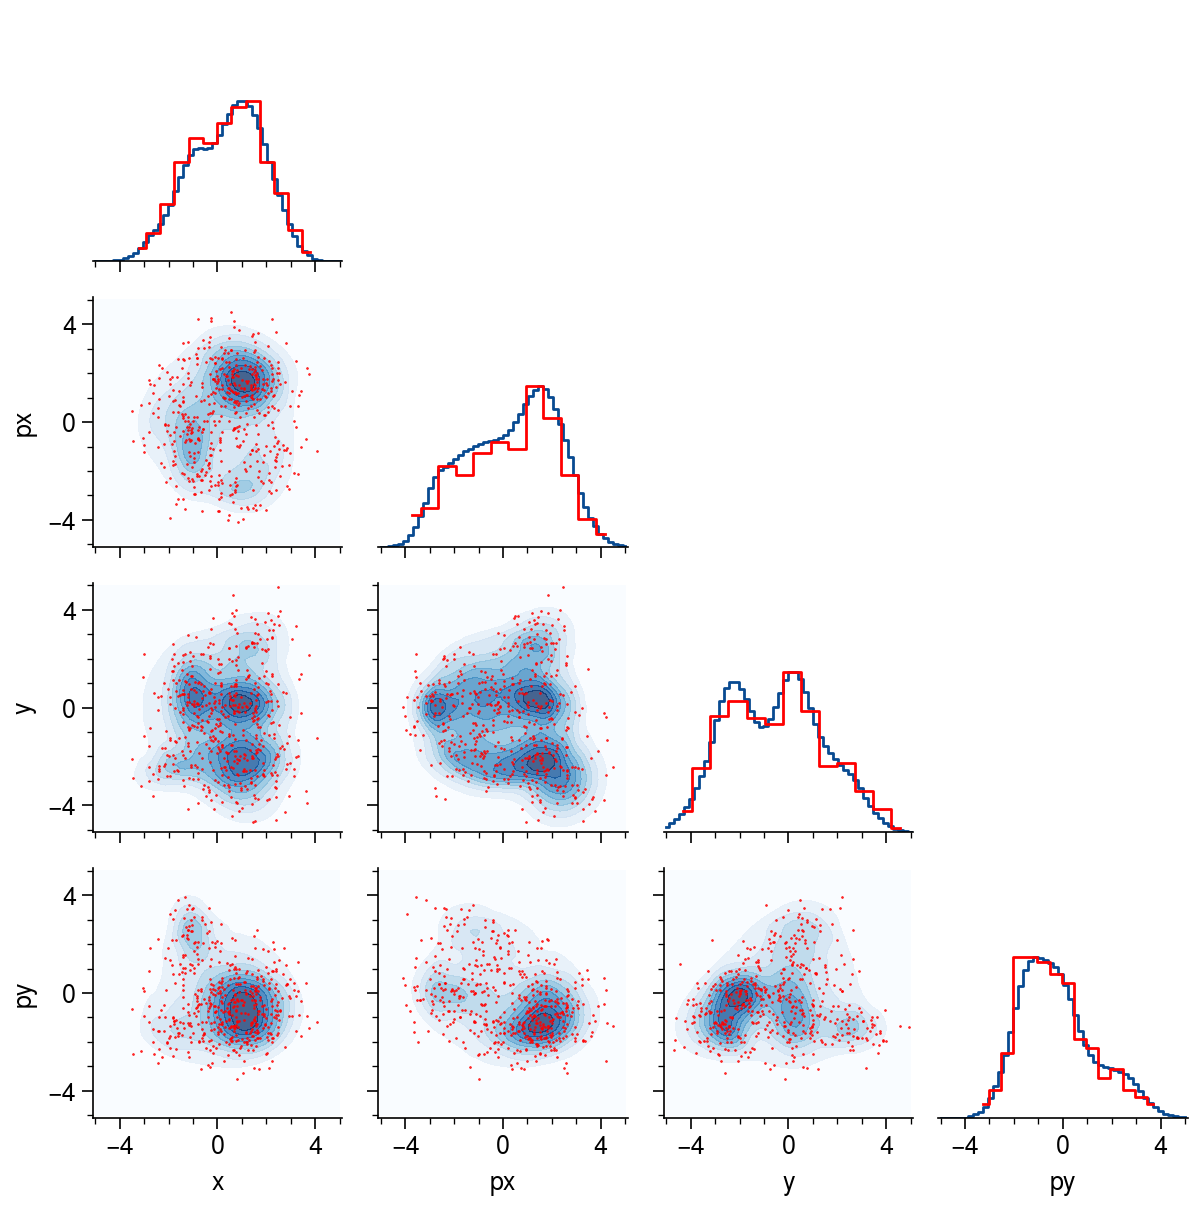

In [9]:
cmap = pplt.Colormap('Blues')
cgrid = psv.CornerGrid(n=f.ndim, diag=True, labels=dims)
cgrid.plot_image(
    f, coords=coords, cmap=cmap, diag_kws=dict(color=cmap(0.9)), 
    kind='contourf',
    alpha=0.75,
)
cgrid.plot_cloud(
    ps.image.sample_grid(f, coords=coords, samples=500),
    update_limits=True,
    diag_kws=dict(color='red'),
    kind='scatter', c='red', s=0.1,
)

### Slice matrix

This plot shows the dependence of the $x$-$p_x$ distribution on $y$ and $y'$: $f(x, p_x | y, p_y)$. The 3D marginal distributions $f(x, p_x, y | p_y)$ and $f(x, p_x, p_y | y)$ are shown on the right and bottom panels. The full projection $f(x, p_x)$ is shown on the bottom right.

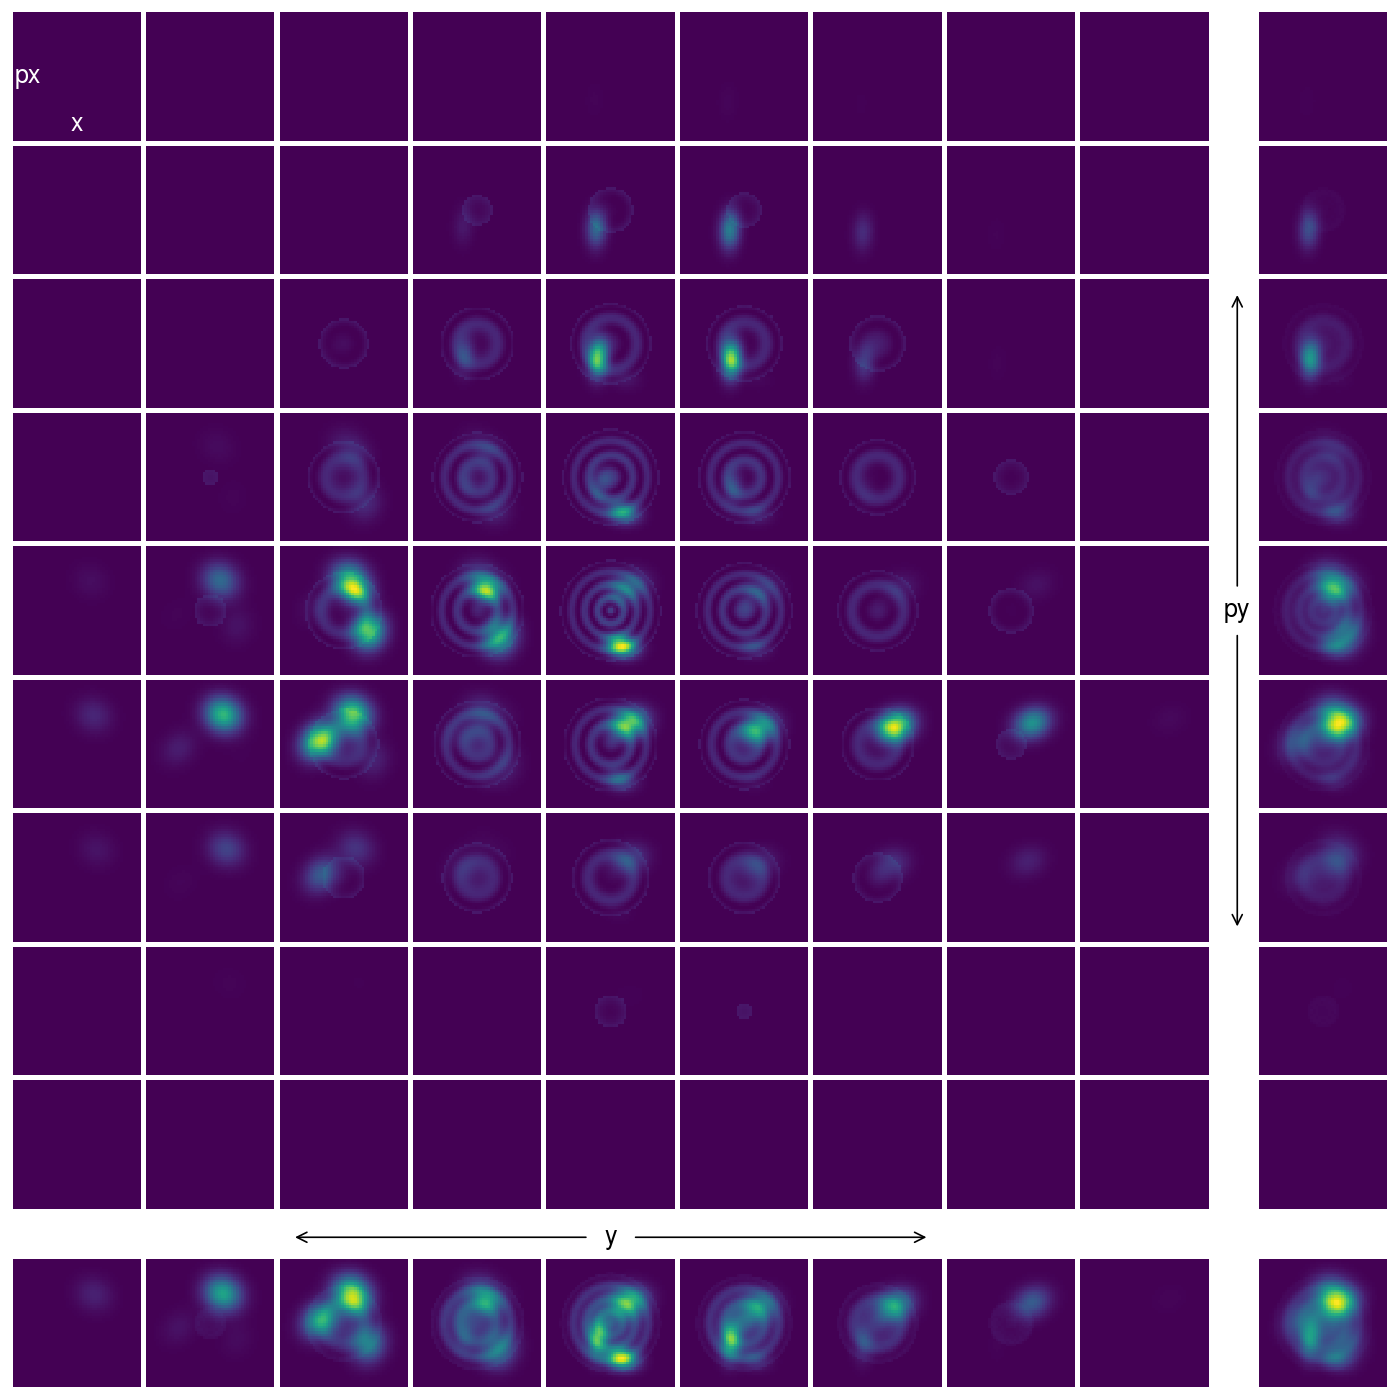

In [10]:
sgrid = psv.SliceGrid(
    nrows=9,
    ncols=9,
    space=0.2,
    gap=2.0,
    marginals=True,  
    annotate=True,
    annotate_kws_view=dict(color='white'),
    annotate_kws_slice=dict(color='black'),
    xspineloc='neither', yspineloc='neither',
    figwidth=7.0,
)
sgrid.plot_image(
    ps.image.project(f, axis=(0, 1, 2, 3)),
    coords=coords,
    labels=dims,
    axis_view=(0, 1),
    axis_slice=(2, 3),
    debug=False,
    vmax=1.0,  # shared cmap
)

(Can also call `psv.image.slice_matrix(f, coords, ...)`.

### 1D projection with interactive slicing

In [11]:
psv.image.proj1d_interactive_slice(f, coords=coords, dims=dims, kind='stepfilled')

interactive(children=(Dropdown(description='dim', options=('x', 'px', 'y', 'py'), value='x'), Checkbox(value=F…

### 2D projection with interactive slicing

In [12]:
psv.image.proj2d_interactive_slice(
    f, coords=coords, dims=dims, profiles_checkbox=True, thresh_slider=False, 
    kind='pcolor'
)

interactive(children=(Checkbox(value=False, description='profiles'), Checkbox(value=False, description='log'),…

### Contour slices

Here, we observe the 1D projection of the distribution within an ($n - 1$)-dimensional contour slice in the other dimensions. See https://arxiv.org/abs/2301.04178.

In [13]:
@interact(
    dim=widgets.Dropdown(options=dims, value=dims[0]),
    levels=widgets.FloatRangeSlider(
        description='(n-1) thresh', min=0.0, max=1.0, value=(0.0, 1.0), step=0.001,
        continuous_update=True,
    ),
)
def update(dim, levels):
    lmin, lmax = levels
    axis = dims.index(dim)
    proj = ps.image.project1d_contour(f, axis=axis, lmin=lmin, lmax=lmax)
    
    fig, ax = pplt.subplots(figsize=(4, 1.5))
    ax.format(xlabel=dims[axis])
    psv.plot1d(coords[axis], proj, ax=ax, kind='step', color='black')
    plt.show()

interactive(children=(Dropdown(description='dim', options=('x', 'px', 'y', 'py'), value='x'), FloatRangeSlider…

We can do the same thing with a 2D projection of the distribution within an ($n - 2$)-dimensional contour slice in the other dimensions.

In [14]:
@interact(
    dim1=widgets.Dropdown(options=dims, value=dims[0]),
    dim2=widgets.Dropdown(options=dims, value=dims[1]),
    levels=widgets.FloatRangeSlider(
        description='(n-2) thresh', min=0.0, max=1.0, value=(0.0, 1.0), step=0.001, 
        readback_format='.3f',
    ),
    log=False,
)
def update(levels, dim1, dim2, log, **plot_kws):
    if dim1 == dim2:
        return
    axis = (dims.index(dim1), dims.index(dim2))
    lmin, lmax = levels
    proj = ps.image.project2d_contour(f, axis=axis, lmin=lmin, lmax=lmax)
    
    fig, ax = pplt.subplots()
    plot_kws['norm'] = 'log' if log else None
    plot_kws.setdefault('process_kws', dict(thresh=0.001, thresh_type='frac'))
    plot_kws.setdefault('colorbar', True)
    plot_kws.setdefault('profx', True)
    plot_kws.setdefault('profy', True)
    plot_kws.setdefault('offset', 1.0 if log else None)
    ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
    psv.image.plot2d(proj, coords=[coords[axis[0]], coords[axis[1]]], ax=ax, **plot_kws)
    ax.format(xlim=sorted(ax.get_xlim()))
    plt.show()

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='(n-2) thresh', max=1.0, step=0.001), Dro…